#  Управление риском ликвидности( Прогнозирование объёмов стабильных средств на рассчётных счетах клиентов)

**Данные** : файл с историческими подневными данными «Сбер» об объемах расчетных счетов физических лиц. 

**Цель** : построить модель для прогнозирования объема стабильных средств клиентов без сроков погашения, в данном конкретном случае это расчетные счета клиентов.Это нужно,чтобы понять возможно ли обеспечение необходимого уровня средств для выполнения стратегических целей Сбера по развитию бизнеса(использовать в долгосрочном / среднесрочном плане,например, для выдачи кредитов). 

Критерии качества модели:

Нужно одновременно минимизировать величины:

- максимальный объем пробития стабильный части на валидационной выборке 

- фактическая стабильная часть – модельная стабильная часть 

 Как вариант: построить квантильную регрессию для прогнозирования ряда.

**Целевой признак:** value  — объём стабильных средств на рассчётных счетах клиентов

<h1>Содержание<span class="tocSkip"></span></h1>
</ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Обучим-модель-линейной-регрессии" data-toc-modified-id="Обучим-модель-линейной-регрессии-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Обучим модель линейной регрессии</a></span></li><li><span><a href="#Обучим-CatBoost-модель" data-toc-modified-id="Обучим-CatBoost-модель-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучим CatBoost модель</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li>

## Подготовка

In [1]:
import pandas as pd

import numpy as np
import math

from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import display

import time

from sklearn.model_selection import train_test_split , cross_val_score,  GridSearchCV  , TimeSeriesSplit 
from sklearn.linear_model import  LinearRegression 
from sklearn.metrics import mean_absolute_error
from sklearn.utils import shuffle
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

In [2]:
state = np.random.RandomState(0)

In [3]:
data = pd.read_csv('input/ВС DS Сбер data.csv')

In [4]:
data.sample(5)

,REPORTDATE;VALUE
302,28.10.2014;16422112115
2068,29.08.2019;61158180425
1507,14.02.2018;47588931812
1344,04.09.2017;40739301242
1769,03.11.2018;57110104838


In [5]:
data[['date', 'value']] = data['REPORTDATE;VALUE'].str.split(';', expand=True)
data.drop('REPORTDATE;VALUE', axis=1, inplace=True)
display(data.sample(5))
display(data.head(7))
display(data.tail(7))

,date,value
771,09.02.2016,19760609856
1373,03.10.2017,42542314178
107,16.04.2014,4750931378
28,27.01.2014,3305963251
1127,30.01.2017,30201771489


,date,value
0,30.12.2013,3457625638
1,31.12.2013,3417092149
2,01.01.2014,3417092149
3,02.01.2014,3417092149
4,03.01.2014,3417092149
5,04.01.2014,3417092149
6,05.01.2014,3417092149


,date,value
2104,04.10.2019,64630140507
2105,05.10.2019,64630140507
2106,06.10.2019,64630140507
2107,07.10.2019,66115288637
2108,08.10.2019,68424049766
2109,09.10.2019,72492897583
2110,10.10.2019,72307860851


In [6]:
data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')
data['value'] = data['value'].astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2111 non-null   datetime64[ns]
 1   value   2111 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 33.1 KB


In [7]:
data.set_index('date', inplace=True)

In [8]:
data[:4]

,value
date,
2013-12-30,3457625638
2013-12-31,3417092149
2014-01-01,3417092149
2014-01-02,3417092149


In [9]:
data.shape

(2111, 1)

In [10]:
data.sort_index(inplace = True)

In [11]:
f"Временной промежуток данных: {data.index.min()} - {data.index.max()}"

'Временной промежуток данных: 2013-12-30 00:00:00 - 2019-10-10 00:00:00'

In [12]:
data.describe()

,value
count,2.111000e+03
mean,3.389668e+10
std,1.875474e+10
min,3.282810e+09
25%,1.824160e+10
50%,3.021352e+10
75%,4.758339e+10
max,7.822860e+10


In [13]:
data['value'].max()

78228598454

In [14]:
data['value'].min()

3282809762

## Анализ

Разложение всего временного ряда на тренд, сезонность и шум.

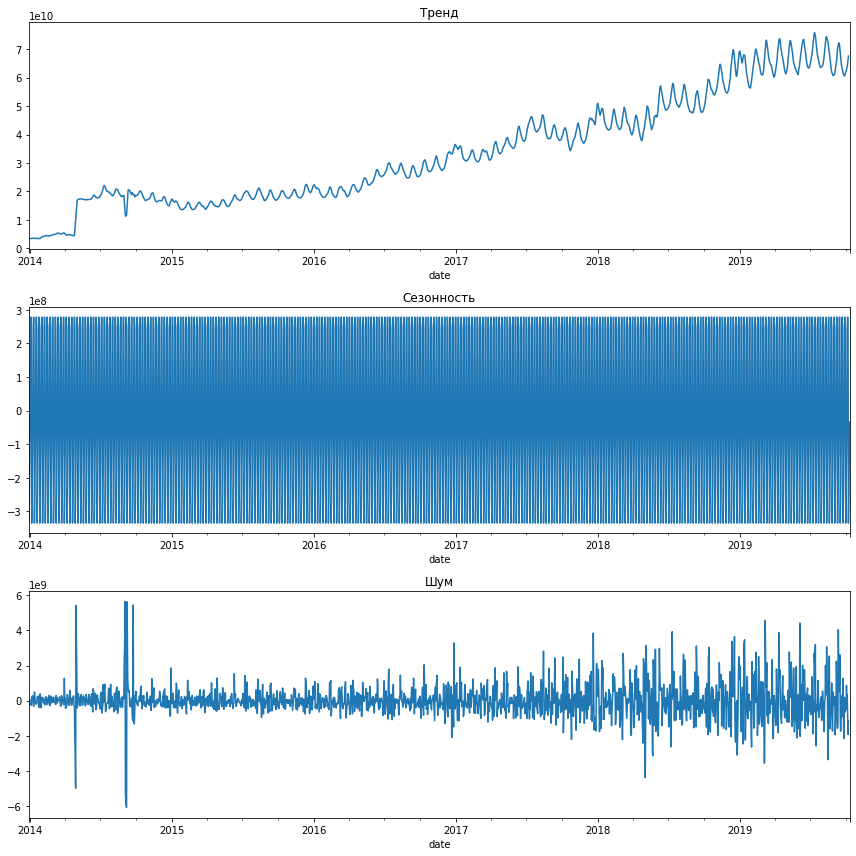

In [15]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Шум')
plt.tight_layout()

Разложение временного ряда 2019 год на тренд, сезонность и шум.

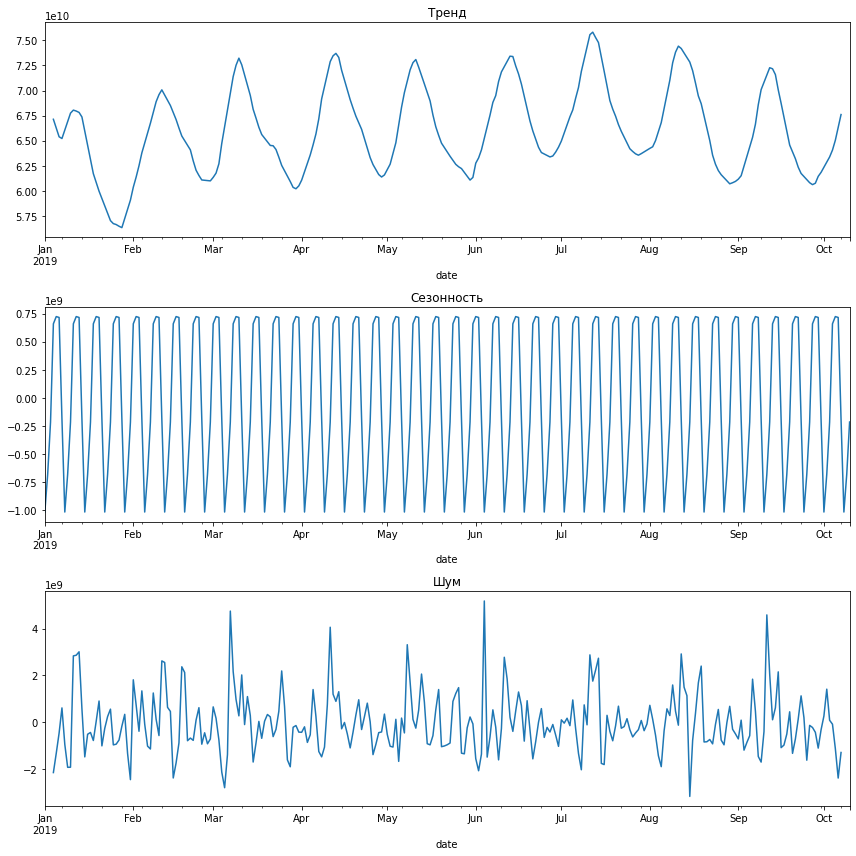

In [16]:
data_2019 = data['2019-01-01':'2019-10-10']

decomposed = seasonal_decompose(data_2019)

plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Шум')
plt.tight_layout()

Разложение временного ряда сентябрь 2019  на тренд, сезонность и шум.

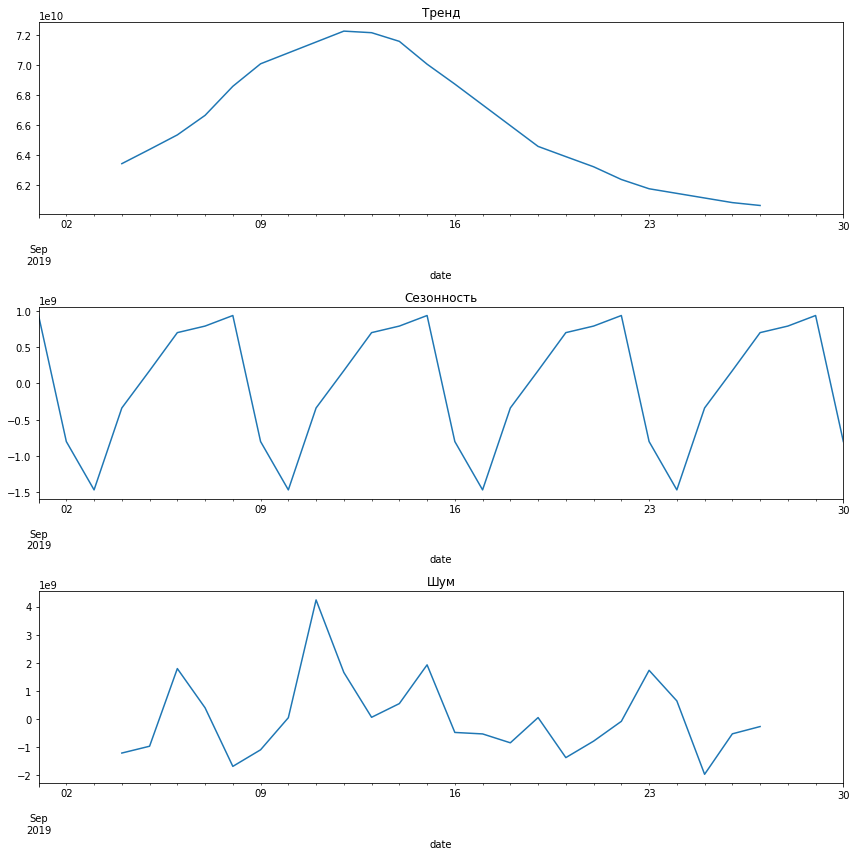

In [17]:
data_09_2019 = data['2019-09-01':'2019-09-30']

decomposed = seasonal_decompose(data_09_2019)

plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Шум')
plt.tight_layout()

**Выводы:**
- Наблюдается тренд линейного роста объема средств на счетах клиентов с периодическими небольшими падениями
- Наблюдается сезонность по неделям - рост объема средств со вторника по воскресенье, пик в воскресенье и спад ко вторнику 
- После удаления тренда и сезонности,остался шум в данных

## Обучение

In [18]:
def make_features(data, max_log, rolling_mean_size, smoothing_factor):
    data_copy = data.copy()  
    data_copy['year'] = data_copy.index.year
    data_copy['month'] = data_copy.index.month
    data_copy['day'] = data_copy.index.day
    data_copy['dayofweek'] = data_copy.index.dayofweek
    
    for lag in range(1, max_log + 1):
        data_copy[f'lag_{lag}'] = data_copy['value'].shift(lag)
        
    #добавление признака скользящего среднего
    data_copy['rolling_mean'] = data_copy['value'].shift().rolling(rolling_mean_size).mean()

    # добавление признака экспоненциально взвешенного среднего
    data_copy['exp_weighted_mean'] = data_copy['value'].ewm(alpha=smoothing_factor).mean()
    
    
    data_copy.dropna(inplace=True)
    
    return data_copy

In [19]:
data = make_features(data,7,7,0.9)
data[:4]

,value,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,exp_weighted_mean
date,,,,,,,,,,,,,,
2014-01-06,3320846785,2014,1,6,0,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.457626e+09,3.422883e+09,3.330471e+09
2014-01-07,3320846785,2014,1,7,1,3.320847e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.403343e+09,3.321809e+09
2014-01-08,3630283744,2014,1,8,2,3.320847e+09,3.320847e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.389593e+09,3.599436e+09
2014-01-09,3618829426,2014,1,9,3,3.630284e+09,3.320847e+09,3.320847e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.420049e+09,3.616890e+09


In [20]:
x = data.drop('value', axis=1)
y = data['value']

x_train, x_test, y_train, y_test = train_test_split(x, y,shuffle=False, test_size=0.1, random_state=state)

f"Размер обучающей выборки: {x_train.shape}",\
f"Размер тестовой  выборки: {x_test.shape}"

('Размер обучающей выборки: (1893, 13)', 'Размер тестовой  выборки: (211, 13)')

In [21]:
Models = []

### Обучим модель линейной регрессии

In [22]:
lr = LinearRegression()
lr.fit(x_train,y_train)
lr_pred = lr.predict(x_train)
mae_lr = mean_absolute_error(y_train,lr_pred)
Models.append(['Линейная регрессия', mae_lr])
mae_lr

7.447926279734004

### Обучим CatBoost модель

In [23]:
cb = CatBoostRegressor(verbose=False)
cb.fit(x_train, y_train)
cb_pred = cb.predict(x_train)
mae_cb = mean_absolute_error(y_train, cb_pred)
Models.append(['CatBoost', mae_cb])
mae_cb

188577793.78465906

In [24]:
# Создание ансамбля из двух моделей
ensemble = (lr_pred + cb_pred) / 2

# Определение средней абсолютной ошибки ансамбля
mae_ensemble = mean_absolute_error(y_train, ensemble)
Models.append(['Ensemble',  mae_ensemble])
mae_ensemble

94288896.54574214

Оформим результаты по обучению моделей в таблицу

In [25]:
Models
result = pd.DataFrame(Models, columns=['model', 'mae'])
result

,model,mae
0,Линейная регрессия,7.447926e+00
1,CatBoost,1.885778e+08
2,Ensemble,9.428890e+07


Наименьшей MAE удалось добиться на модели логистической регрессии

## Тестирование

In [26]:
predictions = lr.predict(x_test)
mae = mean_absolute_error(y_test,predictions)
mae

13.889156902005887

Построим графики исходного и предсказанного рядов

<AxesSubplot:xlabel='date'>

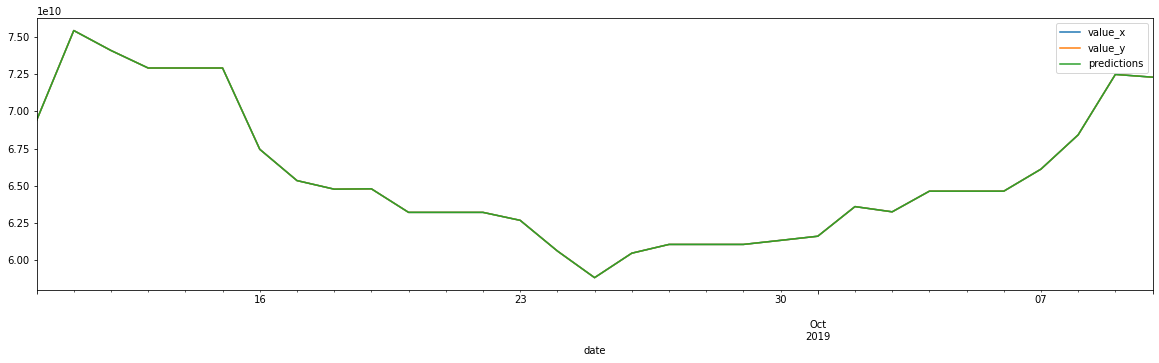

In [27]:
real = y_test
pred = pd.DataFrame(data = predictions, columns = ['value'], index = x_test.index)
values= pd.merge(real, pred, how = 'left', left_index = True, right_index = True)
values['predictions'] = predictions 
values['predictions'] = values['predictions'].astype('int64')
values['2019-09-10':'2019-10-10'].plot(figsize=(20,5))

Модель достаточно хорошо предсказывает объём рассчетных счетов клиентов, рекомендуем заказчику модель линейной регрессии